In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import re


In [ ]:
# Load the cleaned_ebay_deals.csv dataset
df = pd.read_csv('cleaned_ebay_deals.csv')

In [ ]:
#  Remove rows with missing values 
df = df.dropna(subset=['price', 'original_price', 'shipping', 'discount_percentage'])
print(f"Data shape after dropping missing rows: {df.shape}")

Data shape after dropping missing rows: (3975, 7)


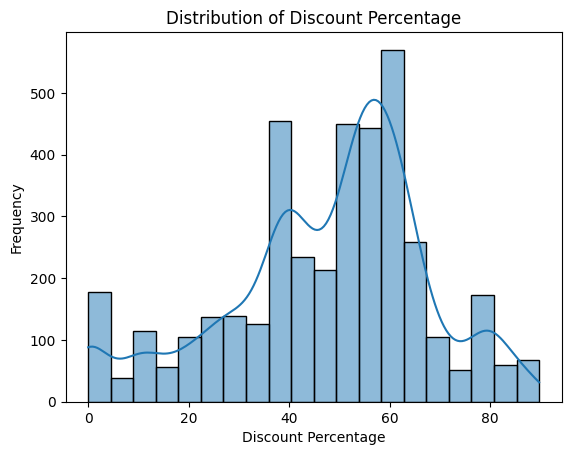

In [ ]:
#Plot a histogram or density plot to visualize the distribution of discount_percentage. 
sns.histplot(df['discount_percentage'], kde=True, bins=20)
plt.title('Distribution of Discount Percentage')
plt.xlabel('Discount Percentage')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Part 3
df['discount_percentage'] = pd.to_numeric(df['discount_percentage'], errors='coerce')
df = df.dropna(subset=['discount_percentage'])

# Create a new column discount_bin by dividing discount_percentage into three categories
bins = [0, 10, 30, np.inf]
labels = ['Low', 'Medium', 'High']
df['discount_bin'] = pd.cut(df['discount_percentage'], bins=bins, labels=labels, right=True, include_lowest=True)

# Count the Number of Samples in Each Category 
bin_counts = df['discount_bin'].value_counts()
print("Original counts per discount bin:")
print(bin_counts)

# Balance the Dataset 

min_count = bin_counts.min()
balanced_df = df.groupby('discount_bin', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))
print("\nBalanced counts per discount bin:")
print(balanced_df['discount_bin'].value_counts())

# Remove discount_bin Column 
balanced_df = balanced_df.drop(columns='discount_bin')



Original counts per discount bin:
discount_bin
High      3226
Medium     488
Low        261
Name: count, dtype: int64

Balanced counts per discount bin:
discount_bin
Low       261
Medium    261
High      261
Name: count, dtype: int64


C:\Users\abouo\AppData\Local\Temp\ipykernel_5140\3271007748.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balanced_df = df.groupby('discount_bin', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))
C:\Users\abouo\AppData\Local\Temp\ipykernel_5140\3271007748.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('discount_bin', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))


In [ ]:

# Cleaning the Shipping Column 
def convert_shipping_value(x):
    if isinstance(x, str):
        # Remove any non-numeric characters (except for the decimal point)
        cleaned = re.sub(r'[^\d.]+', '', x)
        if cleaned:
            try:
                return float(cleaned)
            except ValueError:
                return np.nan
        else:
            # If no numeric value is found, assume free shipping (0.0)
            return 0.0
    return x

balanced_df['shipping'] = balanced_df['shipping'].apply(convert_shipping_value)
balanced_df = balanced_df.dropna(subset=['shipping'])

# Part 4
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Select the input features (price, original_price, shipping) and the target variable (discount_percentage)
X = balanced_df[['price', 'original_price', 'shipping']]
y = balanced_df['discount_percentage']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model using various regression metrics:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nRegression Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Regression Model Evaluation Metrics:
Mean Absolute Error (MAE): 11.36
Mean Squared Error (MSE): 219.37
Root Mean Squared Error (RMSE): 14.81
R² Score: 0.59


PART 4: 6: What each metric means and interpret the values 
- **Mean Absolute Error (MAE):**  
  This metric shows the average difference between the predicted discount and the actual discount. With a MAE of 11.36, on average, our predictions miss the actual discount by about 11.36 percentage points.

- **Mean Squared Error (MSE):**  
  This is the average of all squared differences between the predictions and the actual values. A value of 219.37 tells us that some predictions are far off, because squaring makes big errors even bigger.

- **Root Mean Squared Error (RMSE):**  
  RMSE is simply the square root of the MSE, which converts the error back to the original units (percentage points). An RMSE of 14.81 means that, in typical cases, the prediction error is about 14.81 percentage points.

- **R² Score (Coefficient of Determination):**  
  This score indicates how much of the variation in discount percentages is captured by the model. An R² of 0.59 means our model explains 59% of the variation—this is okay, but there’s still room for improvement.



Evaluation Metrics Table:
     Metric       Value
0       MAE   11.361315
1       MSE  219.371410
2      RMSE   14.811192
3  R² Score    0.586173


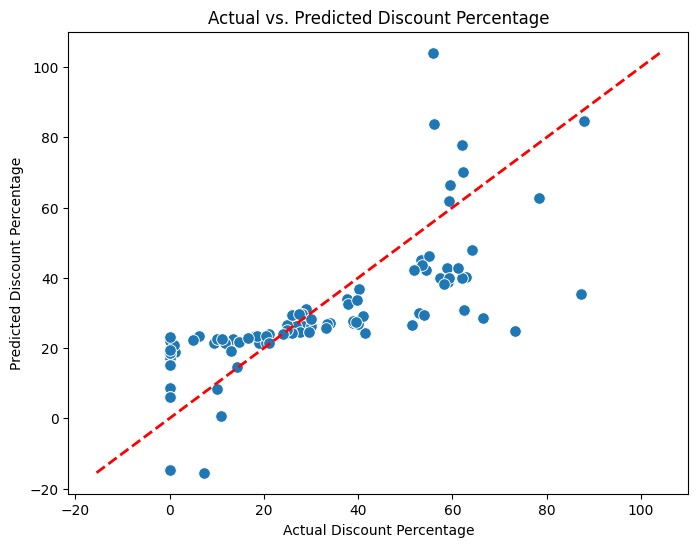

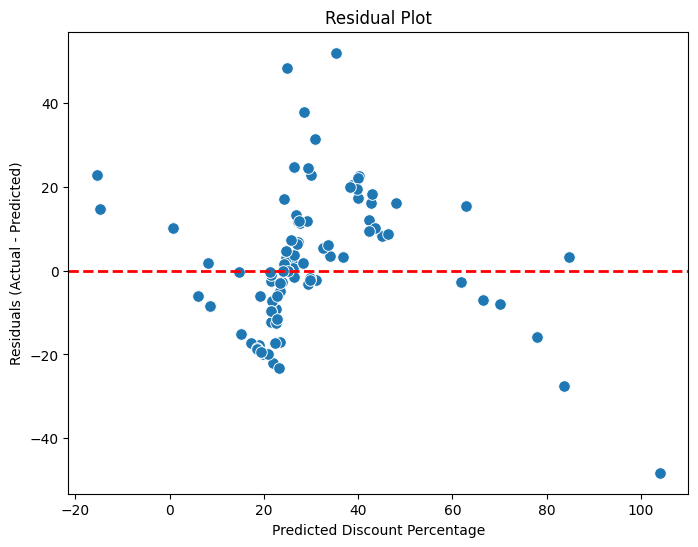

In [ ]:
# Part 5
# Create a table for evaluation metrics
metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R² Score'],
    'Value': [mae, mse, rmse, r2]
}
metrics_table = pd.DataFrame(metrics_data)
print("\nEvaluation Metrics Table:")
print(metrics_table)

# Plot 1: Scatter Plot of Actual vs. Predicted Discount Percentages
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, edgecolor='w', s=70)
plt.xlabel("Actual Discount Percentage")
plt.ylabel("Predicted Discount Percentage")
plt.title("Actual vs. Predicted Discount Percentage")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)
plt.show()

# Plot 2: Residual Plot (Errors = Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, edgecolor='w', s=70)
plt.xlabel("Predicted Discount Percentage")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

In [ ]:
# PART 6: 
# Simulate unseen data by removing the discount_percentage column
incomplete_df = balanced_df.drop(columns=['discount_percentage'])

# Retain only the columns of interest: title, price, original_price, shipping
incomplete_df = incomplete_df[['title', 'price', 'original_price', 'shipping']]

# Randomly select 20 products
sample_incomplete = incomplete_df.sample(n=20, random_state=42)

# Prepare the features for prediction (price, original_price, and shipping must be numeric).
X_incomplete = sample_incomplete[['price', 'original_price', 'shipping']]

# Use the trained model (from Part 4) to predict the discount_percentage
predicted_discount = model.predict(X_incomplete)

# Append the predictions to the sample data.
sample_incomplete.loc[:, 'Predicted Discount (%)'] = predicted_discount


sample_incomplete = sample_incomplete.rename(columns={
    'title': 'Title',
    'price': 'Price',
    'original_price': 'Original Price',
    'shipping': 'Shipping'
})

# Present the results in a table format.
print("\nPredictions on Incomplete Data:")
print(sample_incomplete[['Title', 'Price', 'Original Price', 'Shipping', 'Predicted Discount (%)']])



Predictions on Incomplete Data:
                                                  Title    Price  \
175   Apple iPhone 14 Pro Max 256GB Unlocked Very Go...   539.99   
2231  Sony WF-1000XM5 Truly Wireless Bluetooth Noise...   112.99   
3708  Panasonic Lumix G9 II Mirrorless Black Camera ...  1799.99   
1754  MSI G32C4XS 31.5" FHD Curved Gaming Monitor, 2...   149.99   
3089  Apple iPhone 12 Pro Max A2342 128GB Unlocked G...   387.95   
3306  Lenovo Legion Pro 7 16IRX9H 16" WQXGA 240Hz i9...  1999.00   
2722  Logitech - Z407 2.1 Bluetooth Computer Speaker...    73.00   
3418  Panasonic Lumix G9 II Mirrorless Black Camera ...  1799.99   
3917  ASUS ROG Ally 7" AMD Ryzen Z1 EXTREME FHD 16GB...   419.99   
3161  Lenovo Legion Pro 7 16IRX9H 16" WQXGA 240Hz i9...  1999.00   
2579  Apple iPhone 12 Pro Max A2342 128GB Unlocked G...   392.71   
1278  Acer PredatorNeo Laptop 16 16GB 1TB NVIDIA GeF...   899.99   
2775  Beats Studio Buds + | True Wireless Earbuds, N...    63.74   
1764         Ap